In [ ]:
%reset -f

In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# numpy의 genfromtxt 함수를 사용하여 데이터를 불러옵니다.
data = np.genfromtxt('/content/D1-Pass-or-Fail.txt', delimiter=',')

# 독립 변수 X: 모든 행과 마지막 열을 제외한 모든 열
X = data[:, :-1]

# 종속 변수 y: 모든 행의 마지막 열
y = data[:, -1]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# 결과를 출력해 확인합니다.
print("X:", X)
print("y:", y)

print(X.shape)
print(y.shape)


X: [[34.62365962 78.02469282]
 [30.28671077 43.89499752]
 [35.84740877 72.90219803]
 [60.18259939 86.3085521 ]
 [79.03273605 75.34437644]
 [45.08327748 56.31637178]
 [61.10666454 96.51142588]
 [75.02474557 46.55401354]
 [76.0987867  87.42056972]
 [84.43281996 43.53339331]
 [95.86155507 38.22527806]
 [75.01365839 30.60326323]
 [82.30705337 76.4819633 ]
 [69.36458876 97.71869196]
 [39.53833914 76.03681085]
 [53.97105215 89.20735014]
 [69.07014406 52.74046973]
 [67.94685548 46.67857411]
 [70.66150955 92.92713789]
 [76.97878373 47.57596365]
 [67.37202755 42.83843832]
 [89.67677575 65.79936593]
 [50.53478829 48.85581153]
 [34.21206098 44.2095286 ]
 [77.92409145 68.97235999]
 [62.27101367 69.95445795]
 [80.19018075 44.82162893]
 [93.1143888  38.80067034]
 [61.83020602 50.25610789]
 [38.7858038  64.99568096]
 [61.37928945 72.80788731]
 [85.40451939 57.05198398]
 [52.10797973 63.12762377]
 [52.04540477 69.43286012]
 [40.23689374 71.16774802]
 [54.63510555 52.21388588]
 [33.91550011 98.86943574

In [10]:
import numpy as np
import pandas as pd

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=4):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, 0)

    def _gini_impurity(self, y):
        classes = np.unique(y)
        n_samples = len(y)
        impurity = 1.0
        for cls in classes:
            p_cls = np.sum(y == cls) / n_samples
            impurity -= p_cls ** 2
        return impurity

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        best_feature, best_threshold = None, None
        best_gain = -np.inf
        current_impurity = self._gini_impurity(y)

        if depth == self.max_depth or n_samples < self.min_samples_split:
            leaf_value = np.bincount(y).argmax()
            return leaf_value

        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = X[:, feature_index] < threshold
                right_indices = ~left_indices
                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                left_impurity = self._gini_impurity(y[left_indices])
                right_impurity = self._gini_impurity(y[right_indices])
                left_weight = len(y[left_indices]) / n_samples
                right_weight = len(y[right_indices]) / n_samples

                gain = current_impurity - (left_weight * left_impurity + right_weight * right_impurity)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold

        if best_gain == -np.inf:
            leaf_value = np.bincount(y).argmax()
            return leaf_value

        left = self._build_tree(X[X[:, best_feature] < best_threshold], y[X[:, best_feature] < best_threshold], depth + 1)
        right = self._build_tree(X[X[:, best_feature] >= best_threshold], y[X[:, best_feature] >= best_threshold], depth + 1)

        return Node(feature_index=best_feature, threshold=best_threshold, left=left, right=right)

    def predict(self, X):
        return np.array([self._predict_tree(x, self.tree) for x in X])

    def _predict_tree(self, x, node):
        if isinstance(node, Node):
            if x[node.feature_index] < node.threshold:
                return self._predict_tree(x, node.left)
            else:
                return self._predict_tree(x, node.right)
        return node

    def getTree(self):
        return self.tree

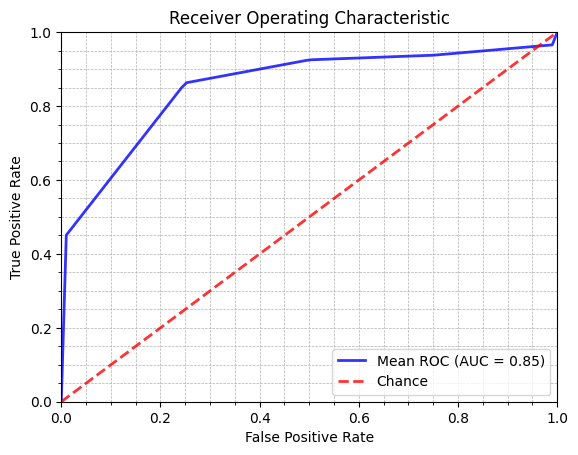


Mean Accuracy: 0.83
Standard Deviation of Accuracy: 0.13
Final Confusion Matrix:
[[32  8]
 [ 9 51]]


In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np

# Stratified k-fold 교차 검증 설정 (10개의 폴드)
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
accuracy_scores = []

# 혼동 행렬 합산
sum_confusion_matrix = None

# ROC 커브를 위한 준비
tprs = []  # True Positive Rates
aucs = []  # Area Under Curve scores
mean_fpr = np.linspace(0, 1, 100)  # 공통 FPR 축

# k-fold 교차 검증 실행
tree_depth = 2
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = DecisionTreeClassifier(max_depth=tree_depth, min_samples_split=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    cm = confusion_matrix(y_test, y_pred)
    if sum_confusion_matrix is None:
        sum_confusion_matrix = cm
    else:
        sum_confusion_matrix += cm
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

# 평균 ROC 커브 플롯
fig, ax = plt.subplots()
ax.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=0.8)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red', label='Chance', alpha=0.8)

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver Operating Characteristic")
ax.legend(loc="lower right")

# Minor grid 추가
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.minorticks_on()

plt.show()

# 결과 출력
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
print(f"\nMean Accuracy: {mean_accuracy:.2f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.2f}")
print("Final Confusion Matrix:")
print(sum_confusion_matrix)


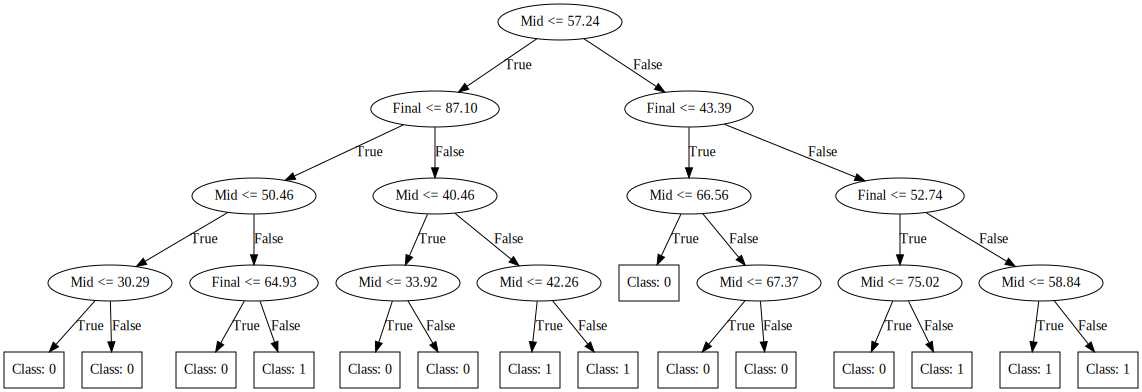

In [11]:
!pip install graphviz
import graphviz

def plot_tree(node, feature_names=None):
    # 그래프 초기화
    dot = graphviz.Digraph()

    def add_nodes_edges(node, parent=None, edge_label=""):
        # 노드 식별자 생성
        node_id = id(node)

        # 리프 노드인 경우
        if not isinstance(node, Node):
            dot.node(str(node_id), label=f"Class: {node}", shape='box')
        else:
            # 노드 라벨 생성
            feature_name = feature_names[node.feature_index] if feature_names else f"X[{node.feature_index}]"
            node_label = f"{feature_name} <= {node.threshold:.2f}"
            dot.node(str(node_id), label=node_label)

        # 부모 노드와의 연결
        if parent:
            dot.edge(str(id(parent)), str(node_id), label=edge_label)

        # 재귀적으로 자식 노드 추가
        if isinstance(node, Node):
            if node.left is not None:
                add_nodes_edges(node.left, node, "True")
            if node.right is not None:
                add_nodes_edges(node.right, node, "False")

    # 루트 노드에서 시작하여 모든 노드와 엣지 추가
    add_nodes_edges(node)

    # 그래프 표시
    return dot


# 모델 생성 및 학습
tree_model = DecisionTreeClassifier(max_depth=4, min_samples_split=2)
tree_model.fit(X, y)

# 트리 시각화
feature_names = ['Mid', 'Final']
dot = plot_tree(tree_model.getTree(), feature_names=feature_names)
dot.render('decision_tree', format='png', cleanup=True)  # PNG 형식으로 저장
dot  # Jupyter 환경에서 바로 시각화
